In [61]:
# IMPORT BLOCK
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import EoN
import time
import seaborn as sns

In [2]:
# GENERIC CODE BLOCK (WILL APPEAR IN ALL NOTEBOOKS)
def run_until_time(G, xmission, recovery, rho, tmax, copy_graph=True):
    """ Runs a basic SIR (cont time) model on graph G 
        with fixed transmission/recovery_rate.
    ARGS:
        G: Networkx graph object
        xmission: float - transmission rate 
        recovery: float - recovery rate 
        rho:  float - fraction of nodes which are randomly 
                initially infected 
        tmax : float - time we run until 
    RETURNS:
        G': networx graph with all IR nodes/edges removed 
        summary: Infection_Summary object which summarizes the run 
                 *** ATTACHES THE .tmax attribute to this object ***
    """
    summary = EoN.fast_SIR(G, xmission, recovery, rho=rho, tmax=tmax, return_full_data=True)
    setattr(summary, 'tmax', tmax)
    # Now collect only the infected/recovered nodes 
    status_dict = _split_summary(summary)
    if copy_graph: 
        G = G.copy()
    if tmax > 0.0:
        G.remove_nodes_from(status_dict.get('I', []))
        G.remove_nodes_from(status_dict.get('R', []))
    
    return G, summary


def _split_summary(summary_obj):
    sort_dict = {} 
    for k, v in summary_obj.get_statuses(time=summary_obj.tmax).items():
        sort_dict[v] = sort_dict.get(v, [])
        sort_dict[v].append(k)
    return sort_dict 


def _cat_summaries(summary_list):
    # Returns, T, S, I, R of multiple runs stacked against each other 
    if not isinstance(summary_list, list):
        summary_list = [summary_list]
    t_lists, s_lists, i_lists, r_lists = [], [], [], [] 
    running_t = 0
    running_r = 0
    for summary in summary_list:
        # Save in-run data
        t_lists.append(running_t + summary.t())
        s_lists.append(summary.S())
        i_lists.append(summary.I())
        r_lists.append(running_r + summary.R())
        
        # add end-time-arrays 
        t_lists.append(np.array([summary.tmax + running_t]))
        s_lists.append(np.array([summary.S()[-1]]))
        i_lists.append(np.array([summary.I()[-1]]))
        r_lists.append(np.array([summary.R()[-1] + running_r]))
        
        # update running_r, running_t 
        running_t += summary.tmax
        running_r += summary.I()[-1] + summary.R()[-1]
        
    # And concatenate everything in the end 
    final_t = np.concatenate(t_lists)
    final_s = np.concatenate(s_lists)
    final_i = np.concatenate(i_lists)
    final_r = np.concatenate(r_lists)
    
    return final_t, final_s, final_i, final_r
        
        
def plot_sir_counts(summary_list, plot_series=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    t, s, i, r = _cat_summaries(summary_list)
    plot_series = plot_series or ['S', 'I', 'R']
    plot_reader = {'S': (s, 'susceptible'),
                   'I': (i, 'infected'), 
                   'R': (r, 'recovered')}
    for series in plot_series:
        data, label = plot_reader[series]
        ax.plot(t, data, label=label)
    ax.legend()
        

def quarantine_cycle(G, tau, gamma, rho, quarantine_times, total_time):
    # quarantine_times is the total times for when quarantines occur 
    # return is the same as the return of _cat_summaries
    if isinstance(quarantine_times, (int, float)):
        quarantine_times = [quarantine_times]
    run_times = [quarantine_times[0]] 
    intervals = quarantine_times + [total_time]
    for i in range(len(intervals) - 1):
        run_times.append(intervals[i+1] - intervals[i])
    print('running qs on series', run_times)
    summary_outs = []
    G = G.copy() 
    for run in run_times:
        G, summary = run_until_time(G, tau, gamma, rho=rho, tmax=run)
        summary_outs.append(summary)
    return _cat_summaries(summary_outs)
    
def selector(els, idxs):
    for idx in idxs:
        yield els[idx]
        
def tuple_filter(tup_iter, idx):
    return [tup[idx] for tup in tup_iter]

        
def c(i):
    return 'bgrcmyk'[i]


# THINGS TO PLOT 
# X-axis: timestep quarantine was performed at 
# Y-axis1: maximum number of infected at any one time 
# Y-axis2: number of recovered at t=infinity (so number of people who got it )

def get_max_I(catsum):
    return max(catsum[2])

def get_final_R(catsum):
    return catsum[3][-1]

def plot_single_qs(qrange, G, tau, gamma, rho, maxt):
    # qrange is a list of 
    #step 1, run each simulation:
    sum_ranges = [] 
    for qseries in qrange:
        print("Running sim on series:", qseries)
        sum_ranges.append(quarantine_cycle(G, tau, gamma, rho, qseries, maxt))
        
    
    #step2, triples we care about (quarantine_time, maxI, finalR)
    triples = [(qrange[i], get_max_I(_), get_final_R(_)) for i,_ in enumerate(sum_ranges)]
    
    # step 3, plot both series
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
    
    return sum_ranges

def max_idx(els):
    return max(((i, e) for i,e in enumerate(els)), key=lambda p: p[1])[0]

def avg(els):
    return sum(els) / len(els)

def get_peak_i(G, tau, gamma, rho, tmax, num_iter=5):
    max_i, max_i_time = [], []
    for i in range(num_iter):
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
        max_i_idx = max_idx(I)
        max_i.append(I[max_i_idx])
        max_i_time.append(t[max_i_idx])
    return avg(max_i), avg(max_i_time)
        
    

In [3]:
# CUSTOM CODE BLOCK (WILL APPEAR ONLY IN THIS NOTEBOOK)
SERIES_IDX = {'S': 1, 'I': 2, 'R': 3}
def plot_vanilla_run(G, tau, gamma, rho, tmax, series='IR'):
    axlist = []
    for serie in series: 
        fig, ax = plt.subplots(figsize=(8,8))

        select = lambda tup: tup[SERIES_IDX[serie]]
        for i in range(5):
            runtup = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
            ax.plot(runtup[0], select(runtup), c='k', alpha=0.3)
        axlist.append(ax)
    if len(axlist) > 1:
        return axlist
    return axlist[0]

def data_getter(G, tau, gamma, rho, tmax, qtimes):
    # For every quarantine-schedule in qtimes: 
    return [quarantine_cycle(G, tau, gamma, rho, _, tmax) for _ in qtimes]

    
    
def plot_maxI_finalR(data, qtimes):
    fig, ax = plt.subplots(figsize=(8,8))
    triples = [(qtime, get_max_I(data[i]), get_final_R(data[i])) for i, qtime in enumerate(qtimes)]
    ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
    ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
    ax.set_xlabel("Quaratine Time")
    ax.set_ylabel("# Individuals")
    ax.legend()
    ax.plot()
    return ax 
    
def plot_SIR_runs(data, qtimes, idx_selectors, series='I'):
    fig, ax = plt.subplots(figsize=(12,12))
    qtimes = list(selector(qtimes, idx_selectors))
    runs = list(selector(data, idx_selectors))
    pairs = [(run[0], run[SERIES_IDX[series]]) for run in runs]
    for i, (qtime, pair) in enumerate(zip(qtimes, pairs)):
        ax.plot(pair[0], pair[1], c=c(i), alpha=0.5, label="Q@ time: %s" % qtime)
    ax.legend()
    return ax


def compare_to_vanilla(vanilla_run, comp_run, series='I'):
    fig, ax = plt.subplots(figsize=(12, 12))
    idx = SERIES_IDX[series]
    ax.plot(vanilla_run[0], vanilla_run[idx], c='k', alpha=0.5, label='vanilla')
    ax.plot(comp_run[0], comp_run[idx], c='b', alpha=0.5, label='comparison')
    ax.legend()
    return ax

In [14]:
N = 10 ** 4
G = nx.barabasi_albert_graph(N, 8)

tmax = 20 
iterations = 5  #run 5 simulations
tau = 0.15        #transmission rate
gamma = 1.0    #recovery rate
rho = 0.005      #random fraction initially infected


In [44]:
# HEATMAPS DONE RIGHT:
# Step 1: Define quarantine grid and run multiple runs (don't need to return full data...)
def get_quarantine_grid_data(G, tau, gamma, rho, tmax, first_qrange, second_qrange, num_iter=3):
    """ G,tau,gamm, rho,tmax are all standard parameters 
        first_qrange is a list of times for the first quarantine 
        second_qrange is a list of times for the second quarantine (e.g., 1 here means do 
        second quarantine 1 time unit after first quarantine)
    Runs quarantine for cartesian product between the two qranges 
    OUTPUT DATA STRUCTURE IS A DICT WITH KEYS BEING TUPLES
    """
    qpairs = [[q0, q1] for q0 in first_qrange for q1 in second_qrange]
    output_data = {}
    for q0, q1 in qpairs:
        pair_runs = [] # (t, S, I, R) tuples in this list
        for i in range(num_iter):
            pair_runs.append(quarantine_cycle(G, tau, gamma, rho, [q0, q0 + q1], tmax))
        output_data[(q0, q1)] = pair_runs
    return output_data
                             
sample_grid = get_quarantine_grid_data(G, tau, gamma, rho, tmax, list(range(5)), list(range(5)))

running qs on series [0, 0, 20]
running qs on series [0, 0, 20]
running qs on series [0, 0, 20]
running qs on series [0, 1, 19]
running qs on series [0, 1, 19]
running qs on series [0, 1, 19]
running qs on series [0, 2, 18]
running qs on series [0, 2, 18]
running qs on series [0, 2, 18]
running qs on series [0, 3, 17]
running qs on series [0, 3, 17]
running qs on series [0, 3, 17]
running qs on series [0, 4, 16]
running qs on series [0, 4, 16]
running qs on series [0, 4, 16]
running qs on series [1, 0, 19]
running qs on series [1, 0, 19]
running qs on series [1, 0, 19]
running qs on series [1, 1, 18]
running qs on series [1, 1, 18]
running qs on series [1, 1, 18]
running qs on series [1, 2, 17]
running qs on series [1, 2, 17]
running qs on series [1, 2, 17]
running qs on series [1, 3, 16]
running qs on series [1, 3, 16]
running qs on series [1, 3, 16]
running qs on series [1, 4, 15]
running qs on series [1, 4, 15]
running qs on series [1, 4, 15]
running qs on series [2, 0, 18]
running 

In [73]:
def process_into_grid(data_dict, func=None):
    if func is None:
        func = lambda x: x 
    
    # First make a grid from the data:
    keys = sorted(data_dict.keys())
    # make rows:(based on first element of key)
    grid = []
    prev_key = keys[0][0]
    current_row = []
    grid_check = []
    current_row_grid_check = []
    for k in keys:
        if k[0] != prev_key:
            grid.append(current_row)
            current_row = [] 
            prev_key = k[0]
            grid_check.append(current_row_grid_check)
            current_row_grid_check = []
        current_row.append(func(data_dict[k]))
        current_row_grid_check.append(k)
    grid.append(current_row)
    grid_check.append(current_row_grid_check)
    return grid, grid_check
        

def avg_max_I(sum_list):
    return sum(get_max_I(_) for _ in sum_list) / float(len(sum_list))

def avg_final_R(sum_list):
    return sum(get_final_R(_) for _ in sum_list) /float(len(sum_list))


def heatmapify(grid, grid_idxs, title=None):
    """ Builds a heatmap and formats it (except for the title) """
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(grid, ax=ax)
    yticks = [_[0][0] for _ in grid_idxs]
    xticks = [_[1] for _ in grid_idxs[0]]
    ax.set_ylabel("Time of first quarantine")
    ax.set_xlabel("Time of second quarantine (after first)")
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)
    if title is not None:
        ax.set_title(title)
    
    
    return ax

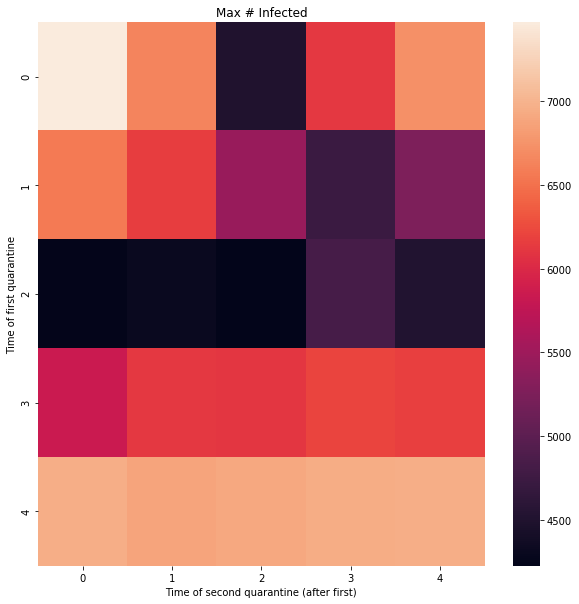

In [75]:
heatmapify(*process_into_grid(sample_grid, avg_final_R), 'Max # Infected')

In [64]:
[_[0][0] for _ in grid_idxs]

[0, 1, 2, 3, 4]

In [19]:
start = time.time()
EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax, return_full_data=True)
print(time.time() - start)

start = time.time()
EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax, return_full_data=False)
print(time.time() - start)

0.40711188316345215
0.20771026611328125


3.5398945808410645


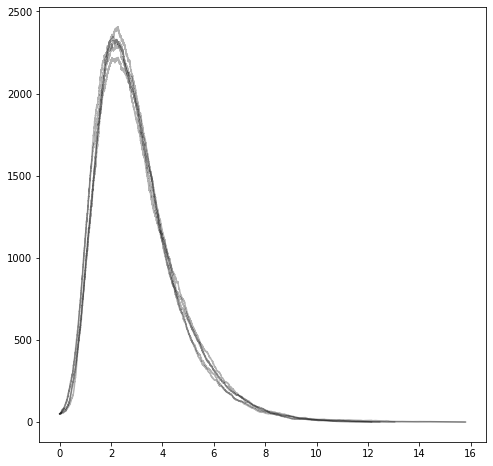

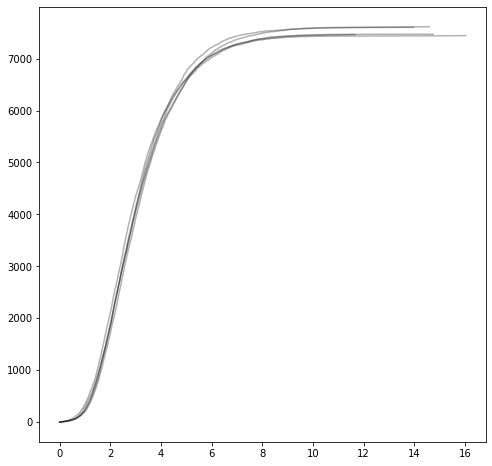

In [6]:
plot_vanilla_run(G, tau, gamma, rho, tmax)

In [ ]:
# EXPERIMENT 1: Infection spreads more slowly after first quarantine:
# Show that time to peak increases after first quarantine
def time_to_second_peak(G, tau, gamma, rho, tmax, qtime):
    g1, summ1 = run_until_time(G, tau, gamma, rho=rho, tmax=qtime)
    g2, summ2 = run_until_time(g1, tau, gamma, rho=rho, tmax=tmax-qtime)
    return summ2.t()[max_idx(summ2.I())]

def avg_by_tt2p(G, tau, gamma, rho, tmax, qtime, num_iter=5):
    times = [time_to_second_peak(G, tau, gamma, rho, tmax, qtime) for _ in range(num_iter)]
    zero_less_times = [_ for _ in times if _ > 0]
    if len(zero_less_times) == 0:
        return 0.0 
    else:
        return sum(zero_less_times) / len(zero_less_times)
    

qtimes = [_ / 10.0 for _ in range(25)]
second_peaks = [(qtime, avg_by_tt2p(G, tau, gamma, rho, 20, qtime)) for qtime in qtimes]

In [ ]:
plt.plot([_[0] for _ in second_peaks], [_[1] for _ in second_peaks])

In [ ]:
qpairs

In [ ]:
# EXPERIMENT 2: Max I/Final R by first_qtime, second_qtime-first_qtime: 
qpairs = [[i / 4.0, i / 4.0 + j / 4.0] for i in range(10) for j in range(10)]
grid_run =data_getter(G, tau, gamma, rho, 20, qpairs)



In [ ]:
# Stack into a 2d array:
empty_grid = [[None for _ in range(10)] for _ in range(10)]
for i, el in enumerate(grid_run):
    empty_grid[i % 10][i // 10] = el
max_i_grid = [[get_max_I(el) for el in row] for row in empty_grid]
last_r_grid = [[get_final_R(el) for el in row] for row in empty_grid]

In [ ]:
import seaborn as sns
ax = sns.heatmap(np.array(max_i_grid))
ax.set_yticklabels([_ / 4.0 for _ in range(10)])
ax.set_xticklabels([_ / 4.0 for _ in range(10)])
ax.set_title("Max # Infected")
ax.set_ylabel("Time of first quarantine")
ax.set_xlabel("Time after first quarantine before second quarantine")

In [ ]:
min_val = float('inf')
min_idx = None
for i, row in enumerate(last_r_grid):
    for j, el in enumerate(row):
        if el < min_val:
            min_val = el 
            min_idx = (i,j)
print(min_val, min_idx)
last_r_grid[7][9]

In [ ]:
qpairs[7 * 10 + 1]

In [ ]:
last_r_grid[]

In [ ]:
last_r_grid[0][0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(np.array(last_r_grid), ax=ax)
ax.set_yticklabels([_ / 4.0 for _ in range(10)])
ax.set_xticklabels([_ / 4.0 for _ in range(10)])
ax.set_title("Final # Recovered")
ax.set_ylabel("Time of first quarantine")
ax.set_xlabel("Time after first quarantine before second quarantine")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))


In [ ]:
# EXPERIMENT 3: Power of the second quarantine: 
# Hypothesis: can use 2 quarantines to drop peak #I by a factor of 4:

def double_peak_cut(G, tau, gamma, rho, tmax):
    # First do a basic run to figure out max peak and the time to apply first quarantine 
    t_, S_, I_, R_ = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
    peak_I = max(I_)
    peak_I_time = t_[max_idx(I_)]
    
    peak_I_quarter = peak_I / 4.0 
    quarter_I_time = 0.0
    for idx, el in enumerate(I_):
        if el > peak_I_quarter:
            quarter_I_time = t_[idx]
            break
    # Now do a run until quarter_time: 
    G1, summ1 = run_until_time(G, tau, gamma, rho, quarter_I_time, copy_graph=True)
    
    # And do another run until peak hits quarter peak:
    t_, S_, I_, R_ = EoN.fast_SIR(G1, tau, gamma, rho=rho, tmax=tmax)
    for idx, el in enumerate(I_):
        if el > peak_I_quarter:
            quarter_I_time = t_[idx]
            break
    G2, summ2 = run_until_time(G1, tau, gamma, rho, quarter_I_time, copy_graph=True)
    G3, summ3 = run_until_time(G2, tau, gamma, rho, tmax, copy_graph=True)
    return summ1, summ2, summ3

summs = list(double_peak_cut(G, tau, gamma, rho, tmax))

In [ ]:
plot_sir_counts(summs, 'I')